## 전처리한 데이터 가지고 오기

In [2]:
%pip install -q lightgbm scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\taka2\.pyenv\pyenv-win\versions\3.10.2\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
df = pd.read_csv('../data/url_metadata_cleaned.csv')

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371357 entries, 0 to 371356
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   url                   371357 non-null  object 
 1   url_type              371357 non-null  int64  
 2   url_len               371357 non-null  int64  
 3   letters_count         371357 non-null  int64  
 4   digits_count          371357 non-null  int64  
 5   special_chars_count   371357 non-null  int64  
 6   shortened             371357 non-null  int64  
 7   is_domain_in_url      371357 non-null  int64  
 8   secure_http           371357 non-null  int64  
 9   have_ip               371357 non-null  bool   
 10  url_region            371357 non-null  object 
 11  root_domain           371227 non-null  object 
 12  redirect_count        371357 non-null  int64  
 13  timeout               371357 non-null  bool   
 14  has_meta_refresh      371357 non-null  bool   
 15  

,url,url_type,url_len,letters_count,digits_count,special_chars_count,shortened,is_domain_in_url,secure_http,have_ip,...,has_meta_refresh,duration_sec,meta_count,link_count,title_count,has_title,has_meta_description,has_og_image,has_og_title,has_link_stylesheet
0,bopsecrets.org/rexroth/cr/1.htm,0,31,25,1,5,0,0,0,False,...,False,6.41,7.0,1.0,1.0,True,False,False,False,True
1,espn.go.com/nba/player/_/id/3457/brandon-rush,0,45,31,4,10,0,0,0,False,...,False,88.17,31.0,62.0,1.0,True,True,True,True,True
2,yourbittorrent.com/?q=anthony-hamilton-soulife,0,46,40,0,6,0,0,0,False,...,False,21.12,4.0,11.0,1.0,True,False,False,False,True
3,allmusic.com/album/crazy-from-the-heat-r16990,0,45,33,5,7,0,0,0,False,...,False,131.85,30.0,52.0,1.0,True,True,True,True,True
4,corporationwiki.com/Ohio/Columbus/frank-s-bens...,0,62,47,7,8,0,0,0,False,...,False,170.81,27.0,15.0,1.0,True,True,True,True,True


特徴量とラベルに分割

In [6]:
# 予測対象（目的変数）
y = df['url_type']  # ← 例：0=benign, 1=phishing, 2=malwareなど

# 特徴量（不要列を除く）
X = df.drop(columns=['url_type'])

X = X.select_dtypes(exclude=['object'])  # 数値型のみ使用（文字列は除外）

学習・検証データに分割

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

LightGBMデータ形式に変換

In [8]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

ハイパーパラメータ設定とモデル学習

In [10]:
params = {
    'objective': 'multiclass',  # ← 多クラス分類なら
    'num_class': y.nunique(),   # クラス数
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1,
}

from lightgbm import early_stopping, log_evaluation

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=100,
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=10)
    ]
)

Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.380679	valid_1's multi_logloss: 0.38101
[20]	training's multi_logloss: 0.312213	valid_1's multi_logloss: 0.313551
[30]	training's multi_logloss: 0.284629	valid_1's multi_logloss: 0.287337
[40]	training's multi_logloss: 0.269159	valid_1's multi_logloss: 0.272938
[50]	training's multi_logloss: 0.259988	valid_1's multi_logloss: 0.264921
[60]	training's multi_logloss: 0.252647	valid_1's multi_logloss: 0.25985
[70]	training's multi_logloss: 0.246947	valid_1's multi_logloss: 0.255181
[80]	training's multi_logloss: 0.242166	valid_1's multi_logloss: 0.251404
[90]	training's multi_logloss: 0.237809	valid_1's multi_logloss: 0.247856
[100]	training's multi_logloss: 0.233863	valid_1's multi_logloss: 0.245029
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.233863	valid_1's multi_logloss: 0.245029


予測と評価

In [11]:
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

print("📊 Classification Report")
print(classification_report(y_test, y_pred))

print("🧩 Confusion Matrix")
print(confusion_matrix(y_test, y_pred))


📊 Classification Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     55444
           1       0.90      0.98      0.94      8556
           2       0.83      0.41      0.55      9293
           3       0.93      0.82      0.87       979

    accuracy                           0.91     74272
   macro avg       0.89      0.80      0.83     74272
weighted avg       0.90      0.91      0.90     74272

🧩 Confusion Matrix
[[54529   186   713    16]
 [  175  8355     8    18]
 [ 4821   652  3791    29]
 [   52    81    45   801]]


重要な特徴量を可視化

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

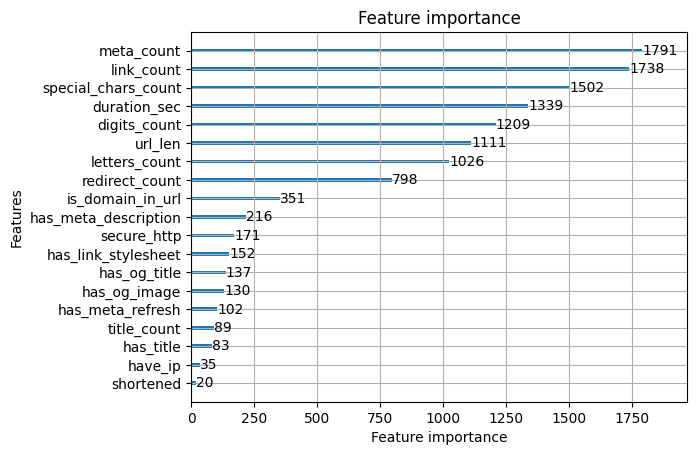

In [ ]:
lgb.plot_importance(model, max_num_features=20)